# Chapter 7: stability selection plots
Plot the result of the variable selection procedure.

In [8]:
import os
import cPickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-paper')
plt.rc('text', usetex=False)

import warnings
warnings.filterwarnings('ignore')

# 0. load `.pkl` files

In [9]:
def load_pkl(filename):
    """Load the input pkl file."""
    with open(filename,'rb') as f:
        dd = pkl.load(f)
    return dd

# Model names
names = ['gradient_boosting', 'random_forests', 'l1l2',
        'l2_logistic_regression', 'l1_logistic_regression',
        'linear_svc_l2', 'linear_svc_l1']

tails = ['_scores', '_coefs']

scores = {}
coefs = {}

# Load the pickles
for name in names:
    try:
        scores[name] = load_pkl(os.path.join('..', '..', 'scripts', 'aism', name+tails[0]+'.pkl'))
        coefs[name] = load_pkl(os.path.join('..', '..', 'scripts', 'aism', name+tails[1]+'.pkl'))
    except:
        print('{} not finished yet'.format(name))

# 1. Plot classification cv scores (step 1)

In [34]:
from scipy.stats import hmean

def plot_score(scores, show_figure=False, tag=''):
    """Plot the scores exploring the scores dictionary.
    
    scores: list of dicts having metrics (recall, AUC, MCC, precision, accuracy) as keys
    save_figure: bool
    tag: filename tail
    """    
    # Init the empty lists
    rcll = []
    auc = []
    mcc = []
    prec = []
    acc = []
    f1 = []
    
    
    # Explore each cv iter
    for cv in scores:
        rcll.append(cv['recall'])
        auc.append(cv['AUC'])
        mcc.append(cv['MCC'])
        prec.append(cv['precision'])
        acc.append(cv['accuracy'])
        f1.append(hmean((cv['precision'], cv['recall'])))
    cv_results_ = {'recall': rcll, 'AUC': auc, 'MCC': mcc,
                   'precision': prec, 'accuracy': acc, 'F1': f1}
    cv_results_ = pd.DataFrame(cv_results_)

    if show_figure:
        plt.figure(dpi=300)
    
        # Plot each metric
        for i, metric in enumerate(cv_results_.columns):
            plt.subplot(3, 2, i+1)
            plt.hist(cv_results_[metric], bins=20)
            plt.title(r'{} = ({:.3f} $\pm$ {:.3f})'.format(metric,
                                                          np.mean(cv_results_[metric]),
                                                          np.std(cv_results_[metric])))
        plt.suptitle('{}'.format(tag.replace('_', ' ').title()), y=1.05)
        plt.tight_layout()
        plt.savefig(os.path.join('..', '..', 'images', 'aism_scores_{}.png'.format(tag)))
    
    return cv_results_

In [36]:
# Create the scoreboard
scoreboard = pd.DataFrame(index=names, columns=[u'AUC', u'MCC', u'accuracy',
                                                u'precision', u'recall', 'F1'])
for name in names:
    df = plot_score(scores[name], show_figure=False, tag=name)
    for col in scoreboard.columns:
        scoreboard[col].loc[name] = r'{:.3f} $\pm$ {:.3f}'.format(df.mean()[col],
                                                                df.std()[col])
scoreboard[scoreboard.columns.drop('AUC')]

,MCC,accuracy,precision,recall,F1
gradient_boosting,0.688 $\pm$ 0.035,0.846 $\pm$ 0.017,0.863 $\pm$ 0.021,0.858 $\pm$ 0.023,0.860 $\pm$ 0.016
random_forests,0.687 $\pm$ 0.032,0.845 $\pm$ 0.016,0.865 $\pm$ 0.019,0.853 $\pm$ 0.021,0.859 $\pm$ 0.014
l1l2,0.612 $\pm$ 0.029,0.804 $\pm$ 0.015,0.850 $\pm$ 0.031,0.789 $\pm$ 0.047,0.817 $\pm$ 0.018
l2_logistic_regression,0.620 $\pm$ 0.032,0.809 $\pm$ 0.016,0.857 $\pm$ 0.020,0.787 $\pm$ 0.027,0.820 $\pm$ 0.016
l1_logistic_regression,0.632 $\pm$ 0.031,0.814 $\pm$ 0.016,0.867 $\pm$ 0.019,0.786 $\pm$ 0.026,0.824 $\pm$ 0.016
linear_svc_l2,0.621 $\pm$ 0.032,0.808 $\pm$ 0.016,0.863 $\pm$ 0.019,0.779 $\pm$ 0.026,0.819 $\pm$ 0.017
linear_svc_l1,0.632 $\pm$ 0.030,0.814 $\pm$ 0.015,0.872 $\pm$ 0.020,0.779 $\pm$ 0.025,0.823 $\pm$ 0.016


In [37]:
scoreboard[scoreboard.columns.drop('AUC')].to_latex('f_scoreboard.tex')

# 2. Plot variable ranking

In [5]:
def flatten(x):
    """Flatten a list."""
    return [y for l in x for y in flatten(l)] if type(x) in (list, np.ndarray) else [x]

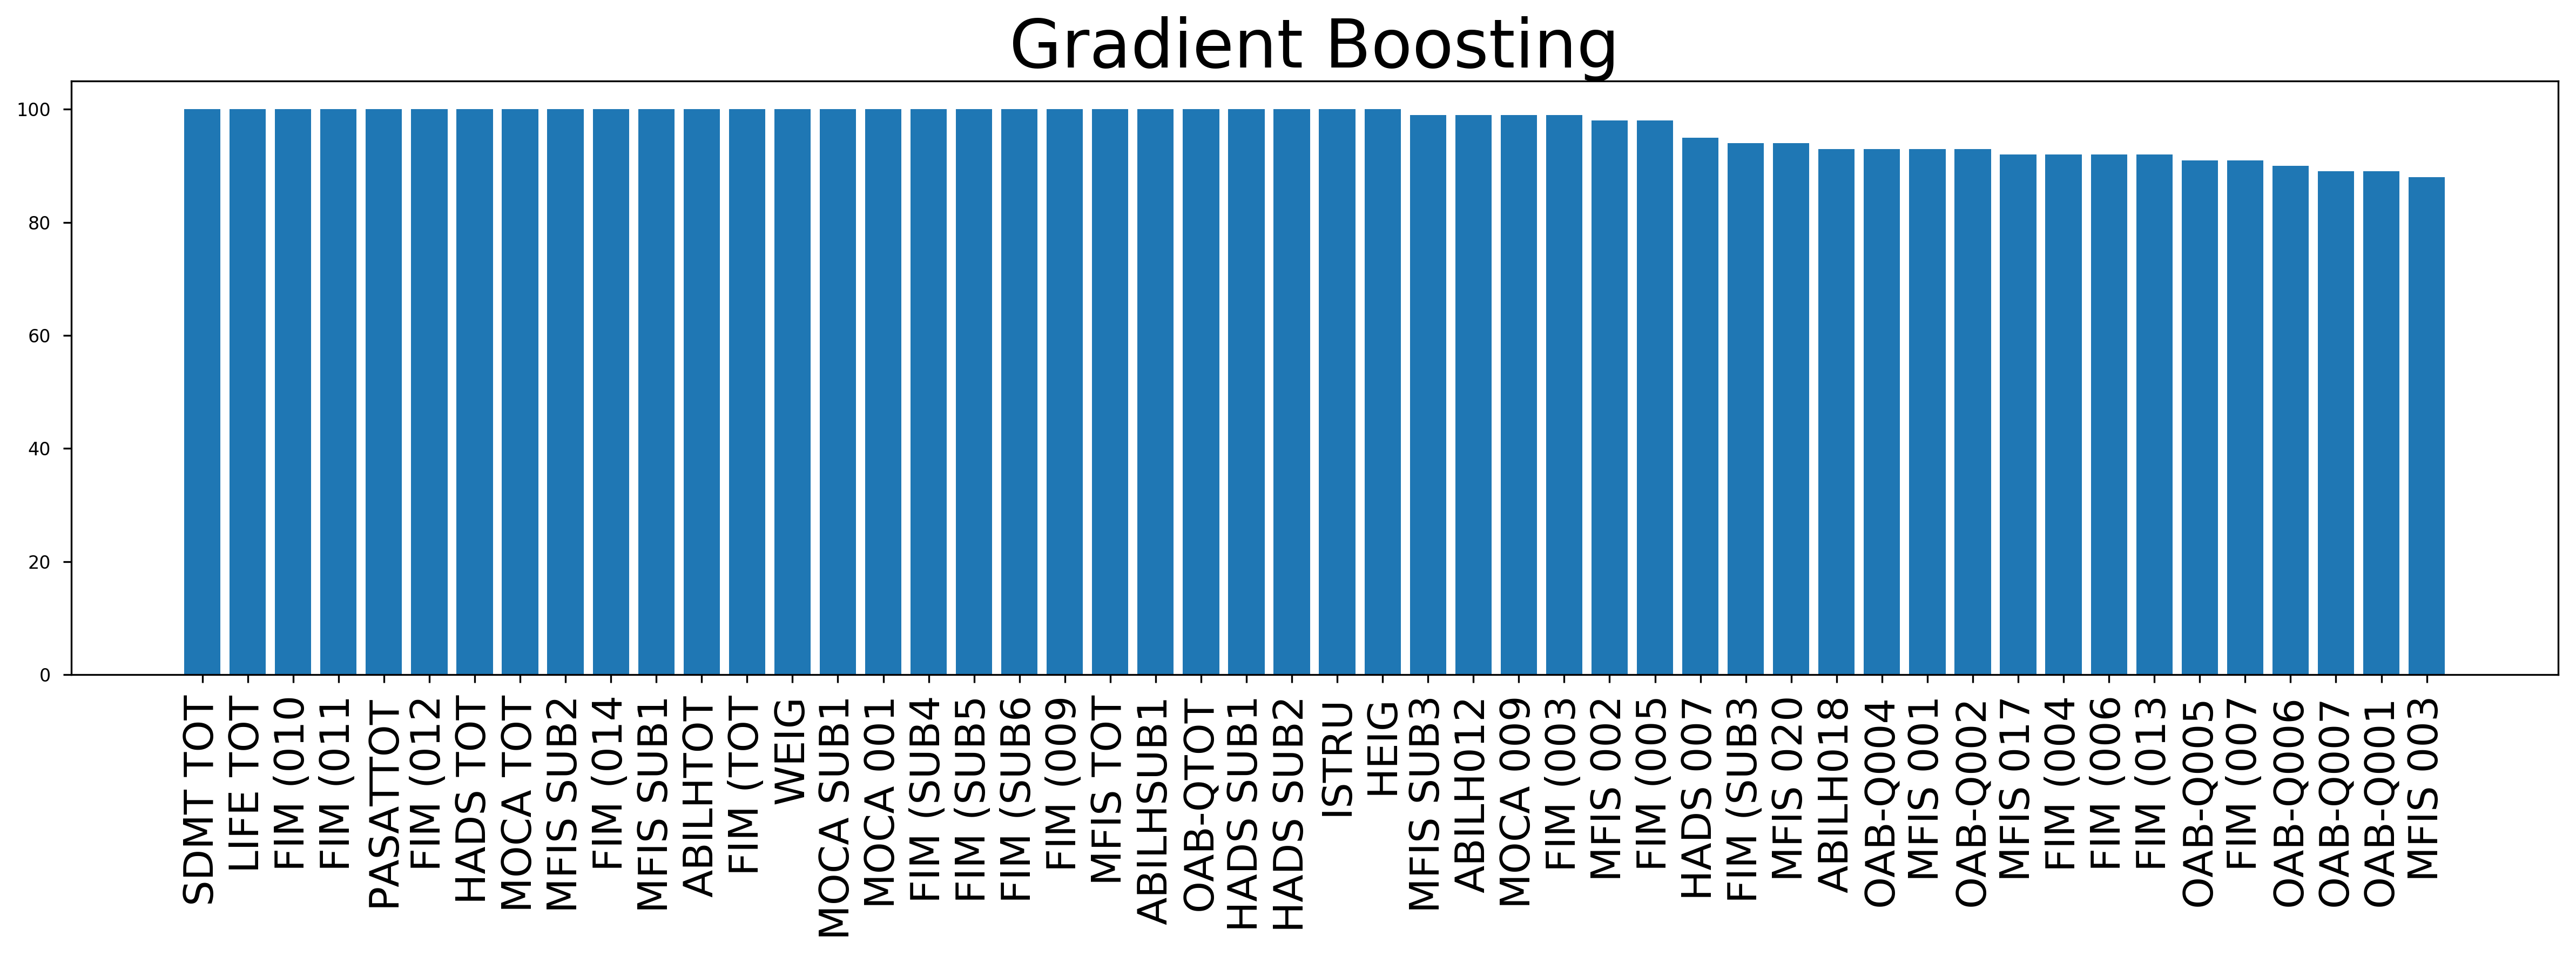

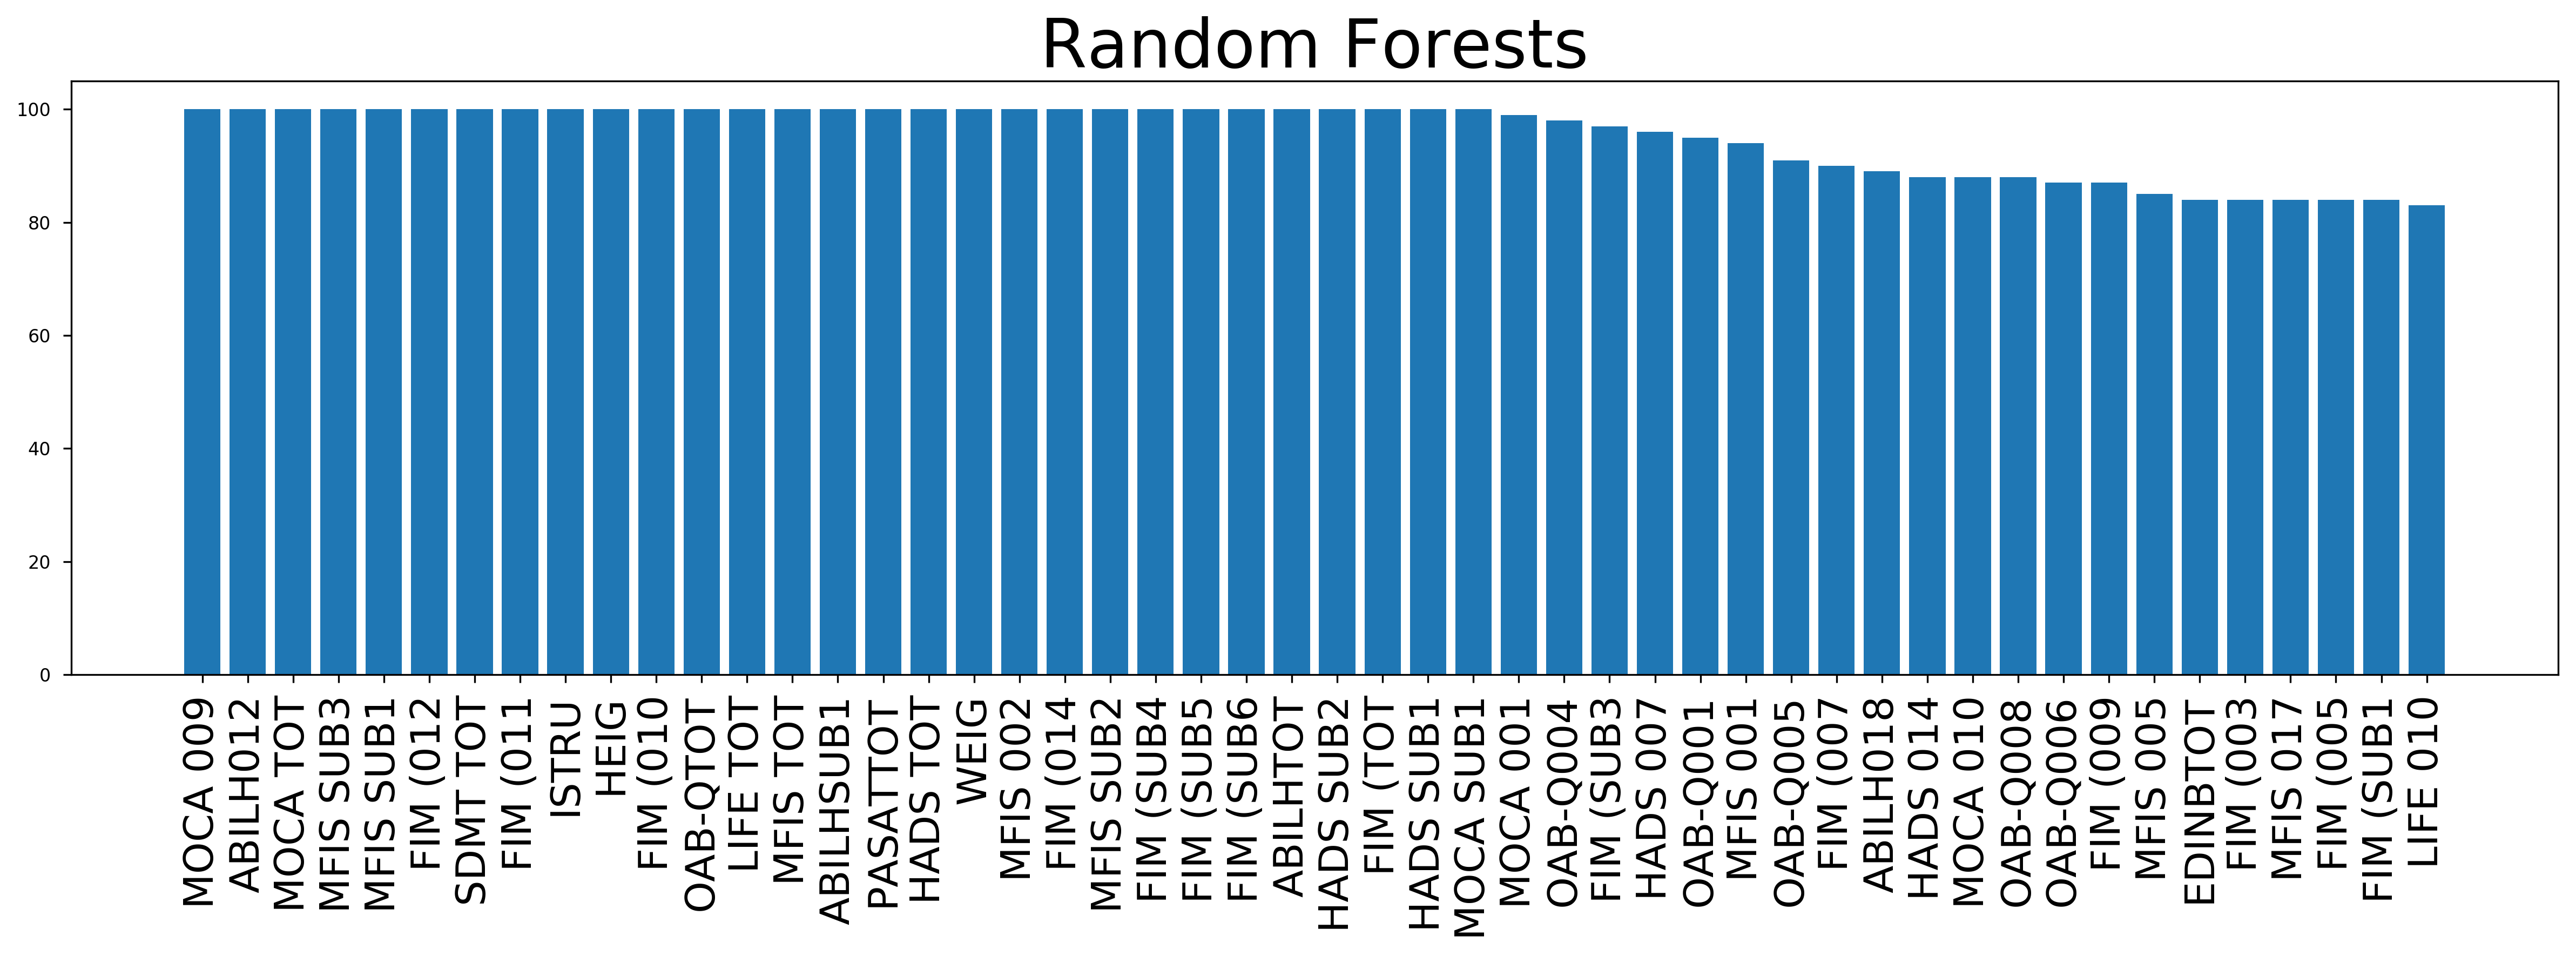

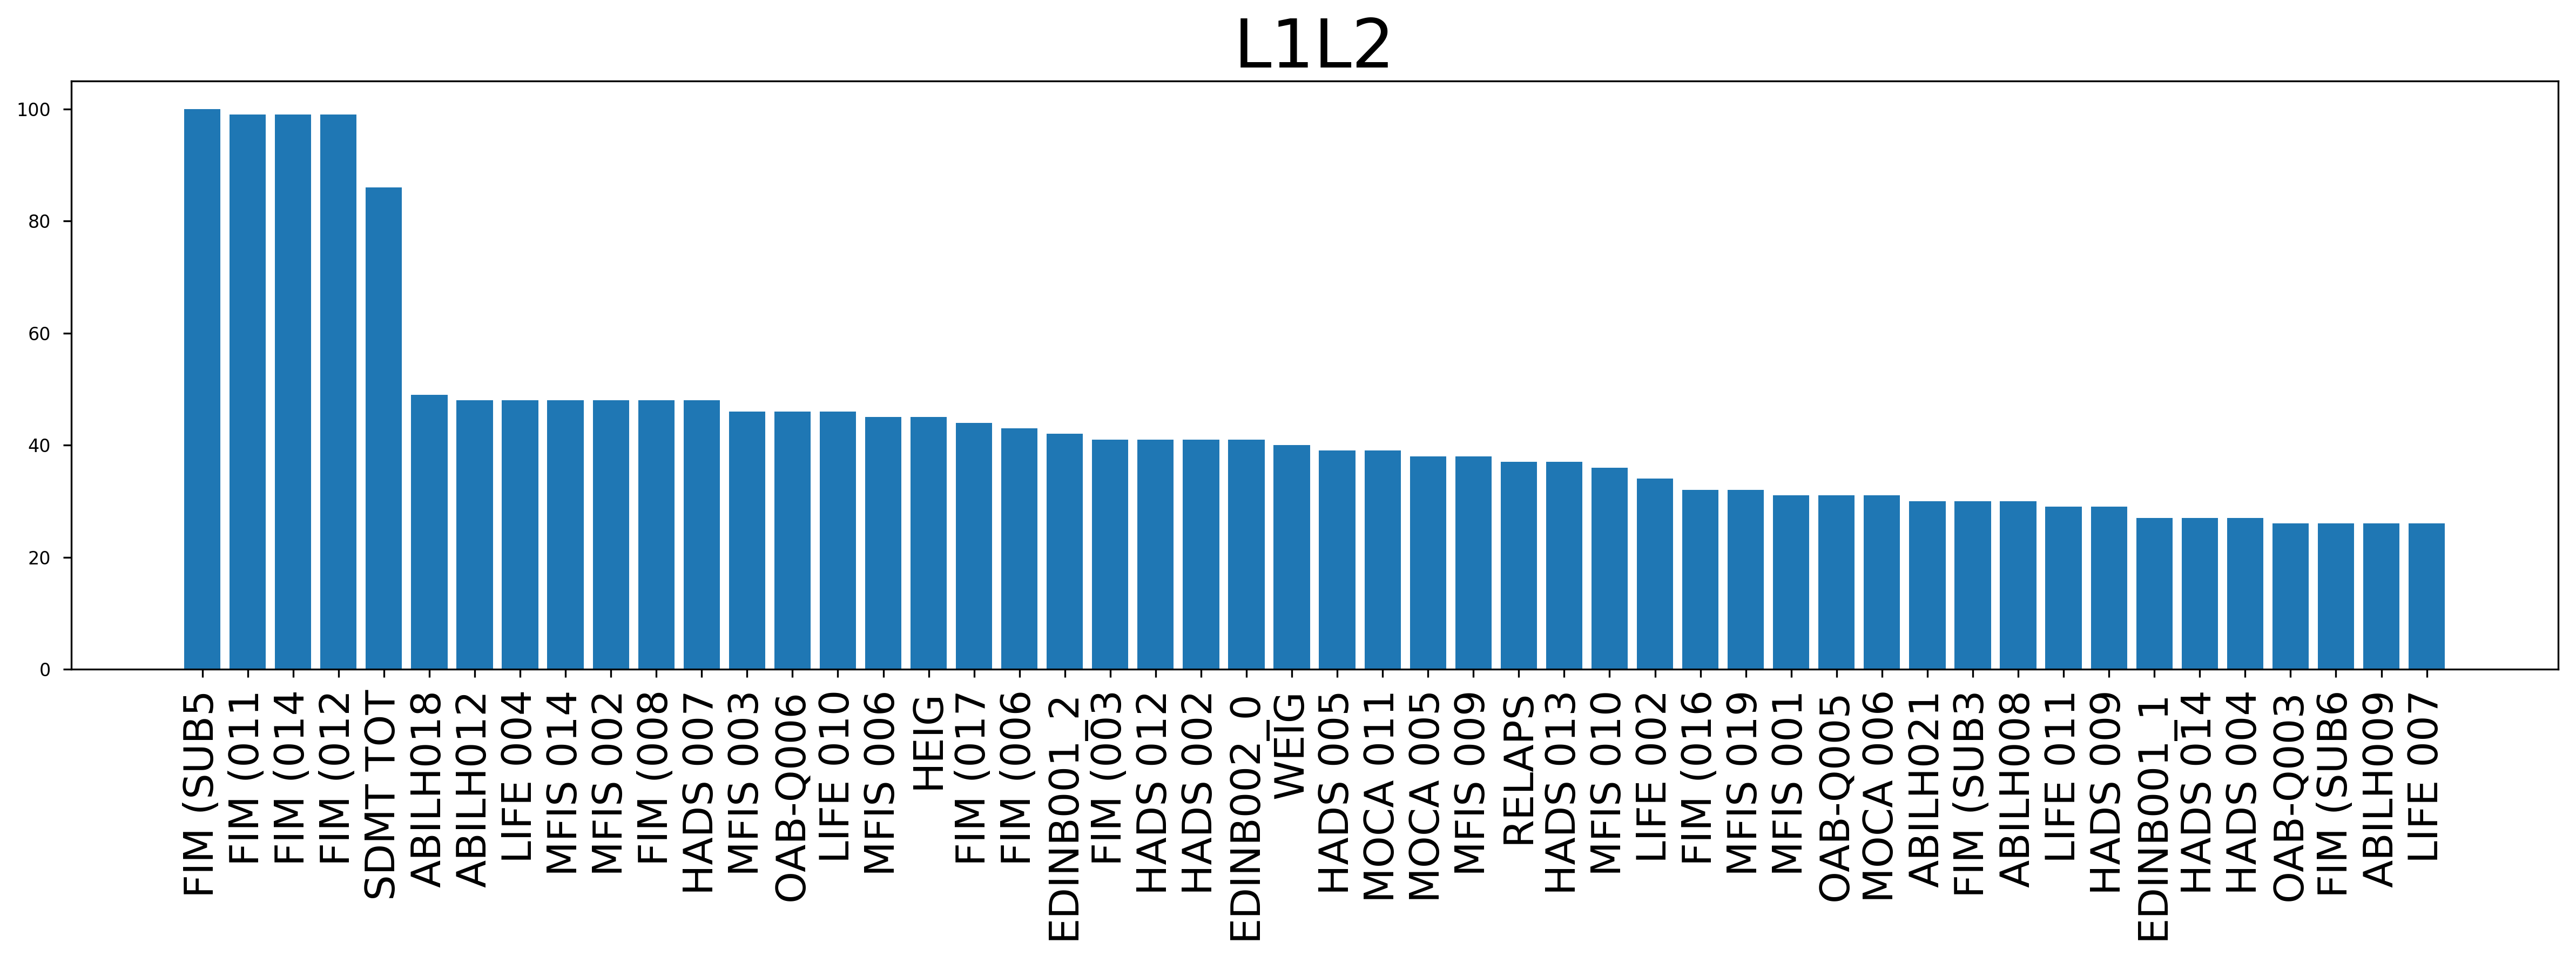

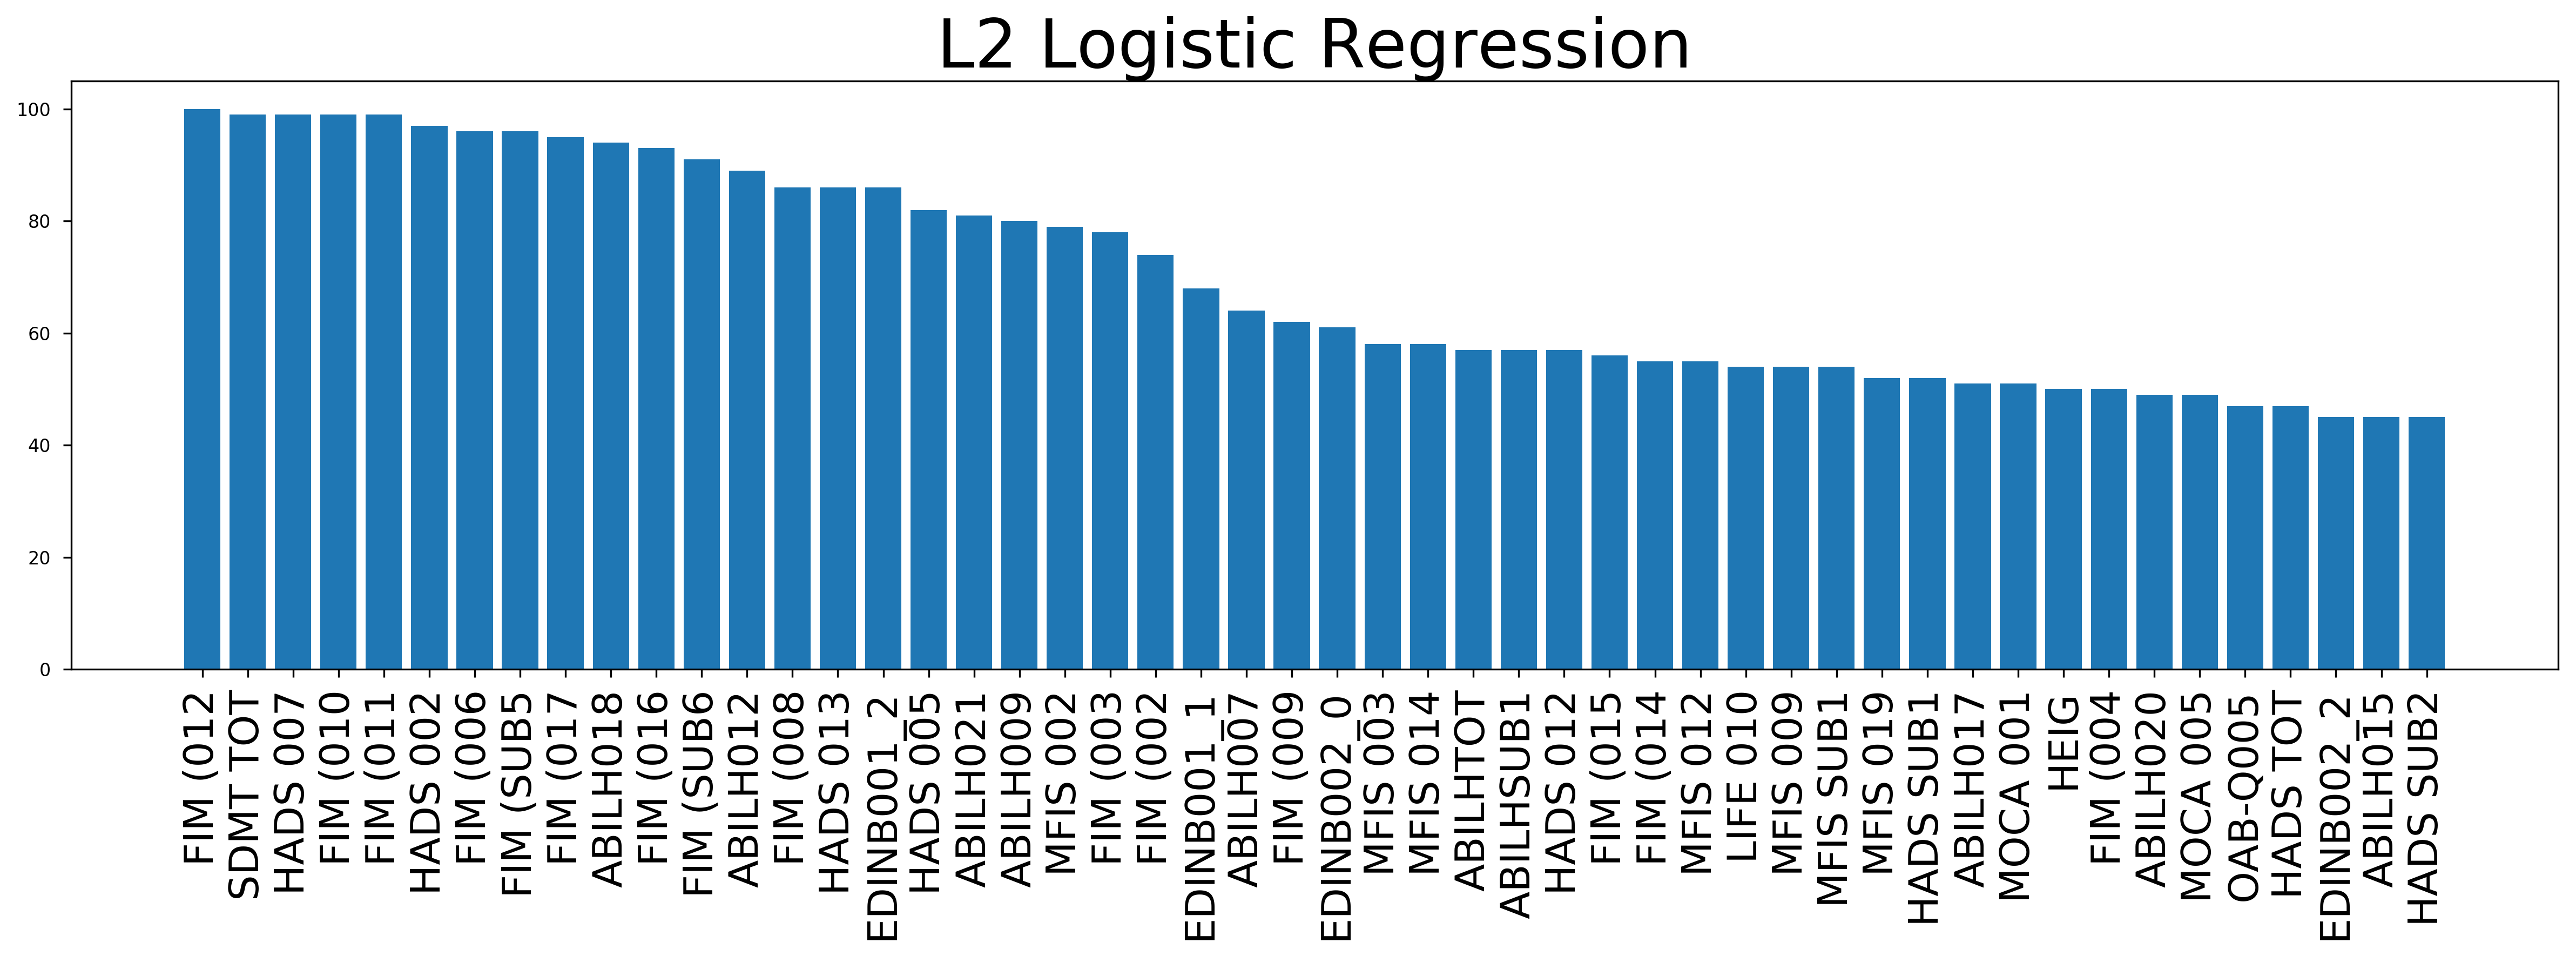

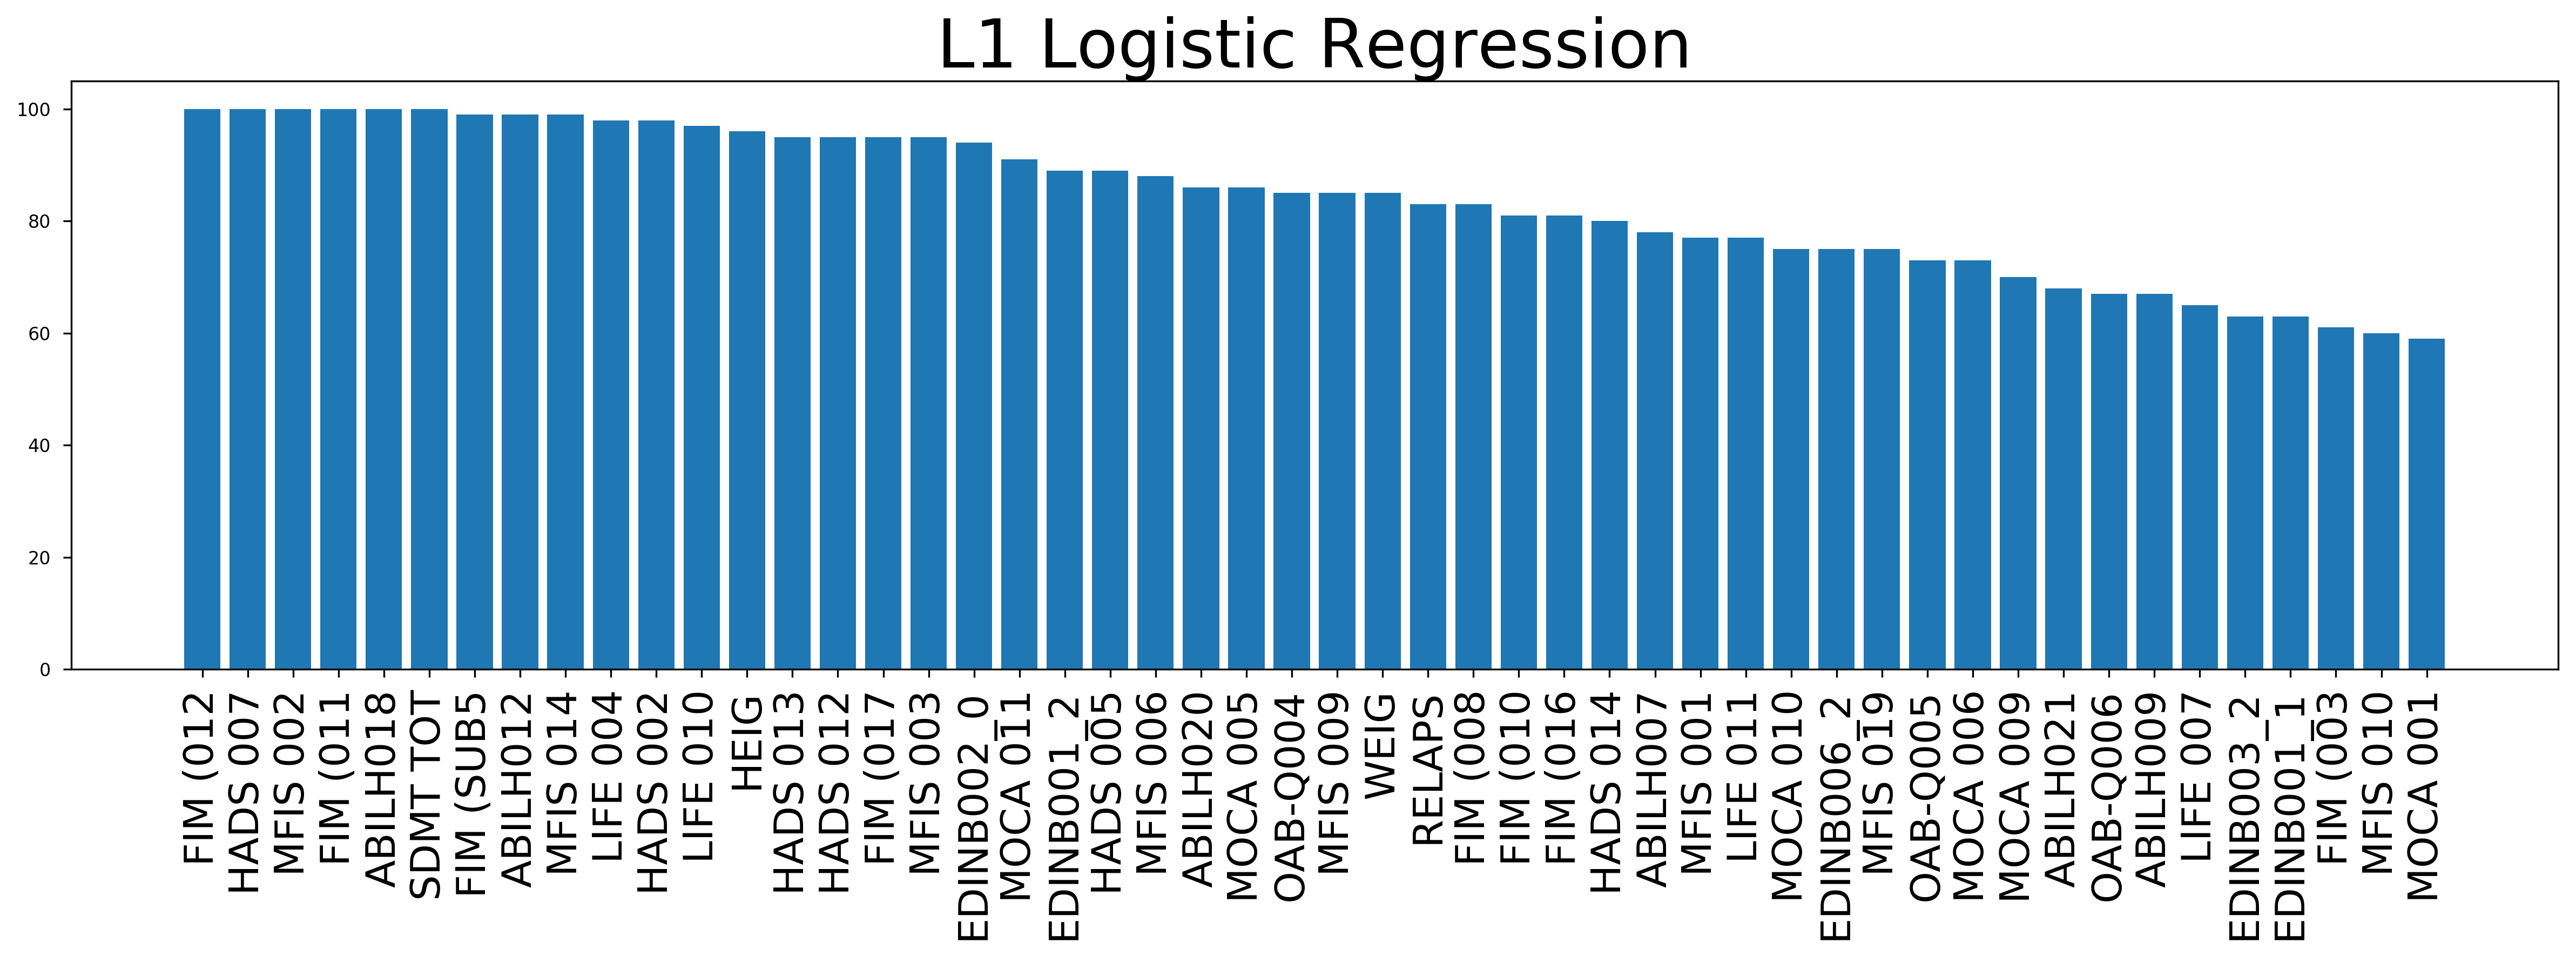

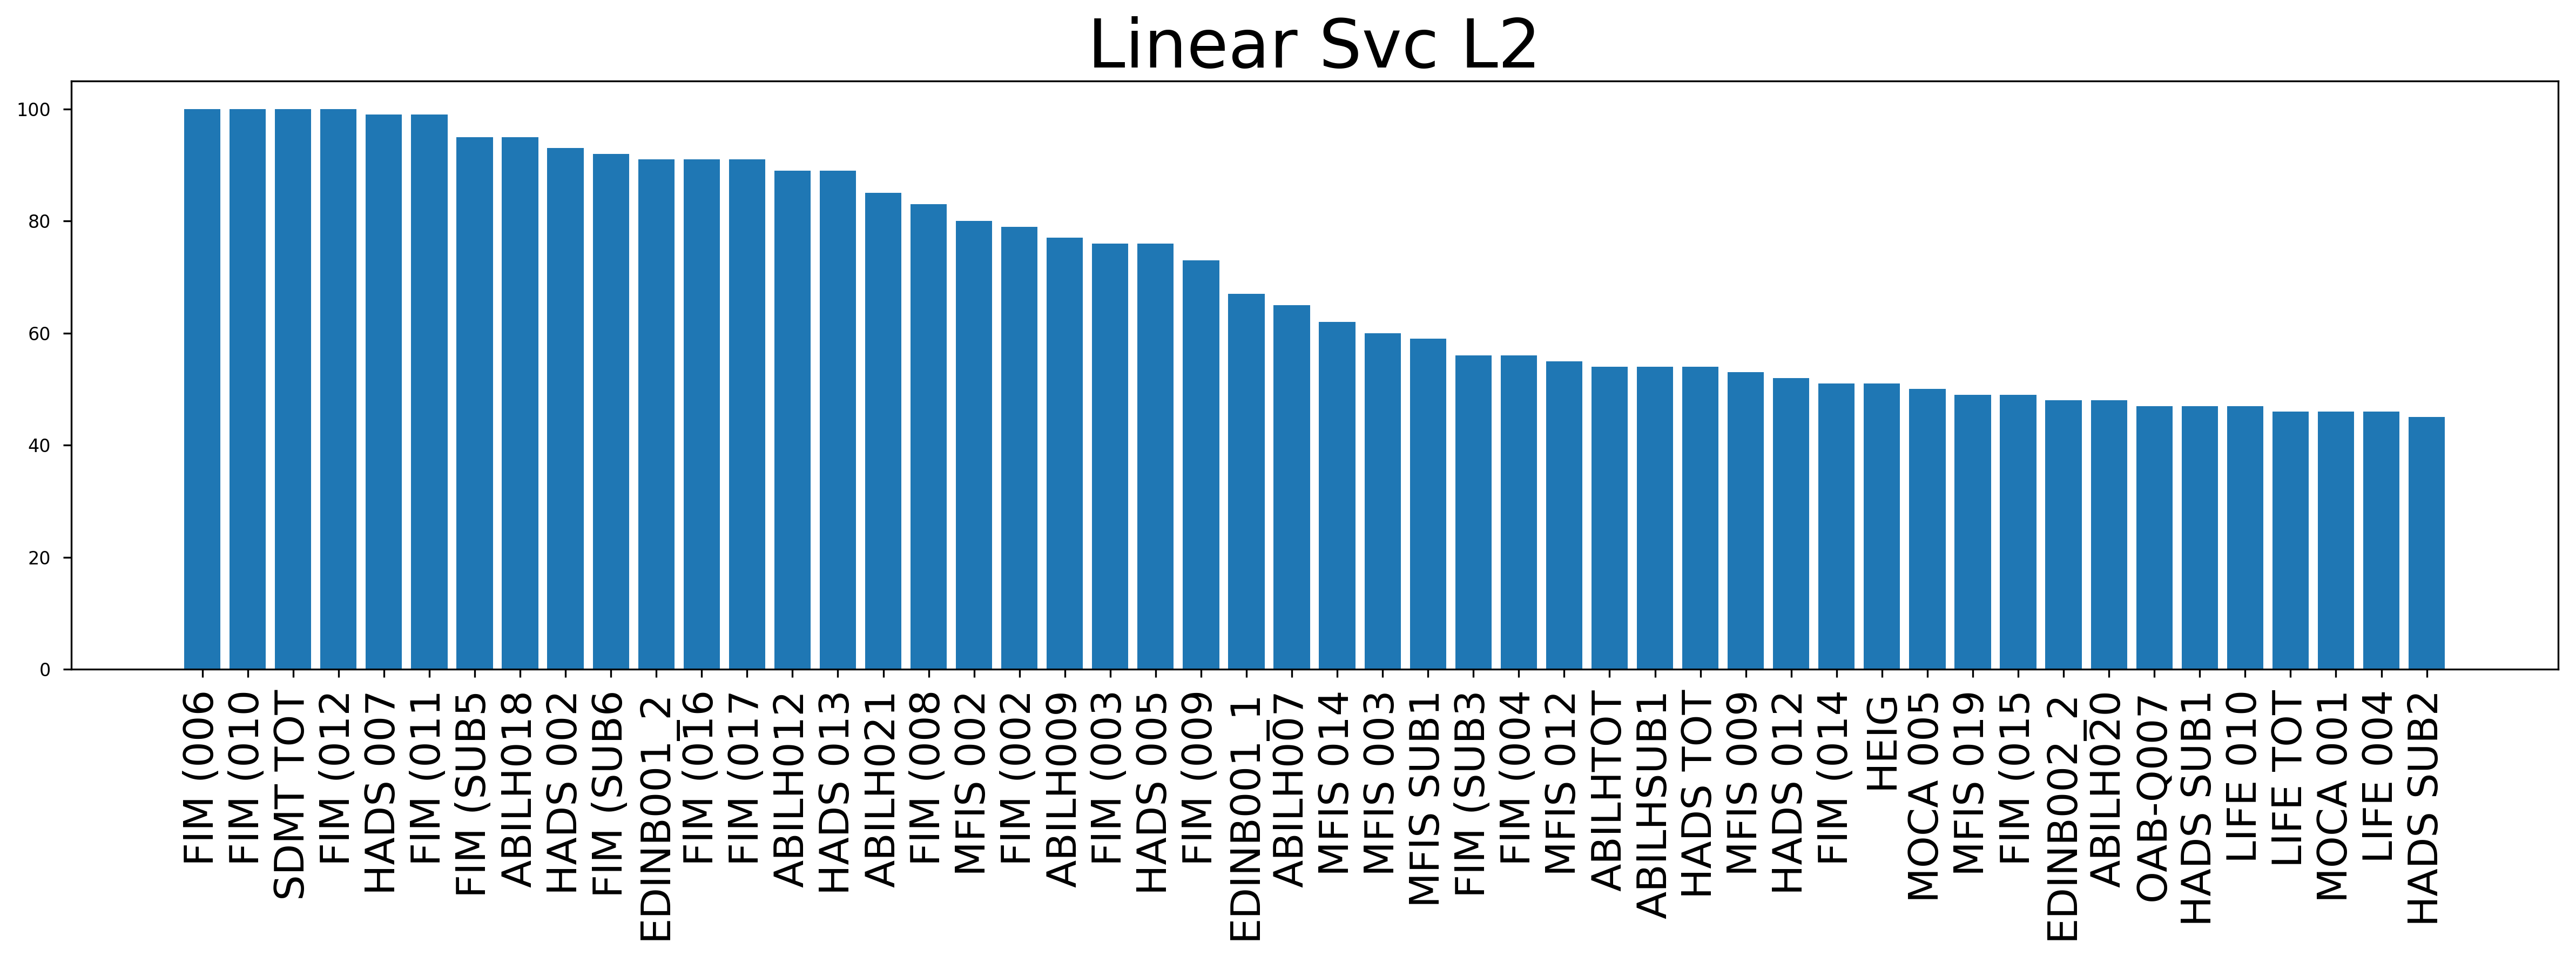

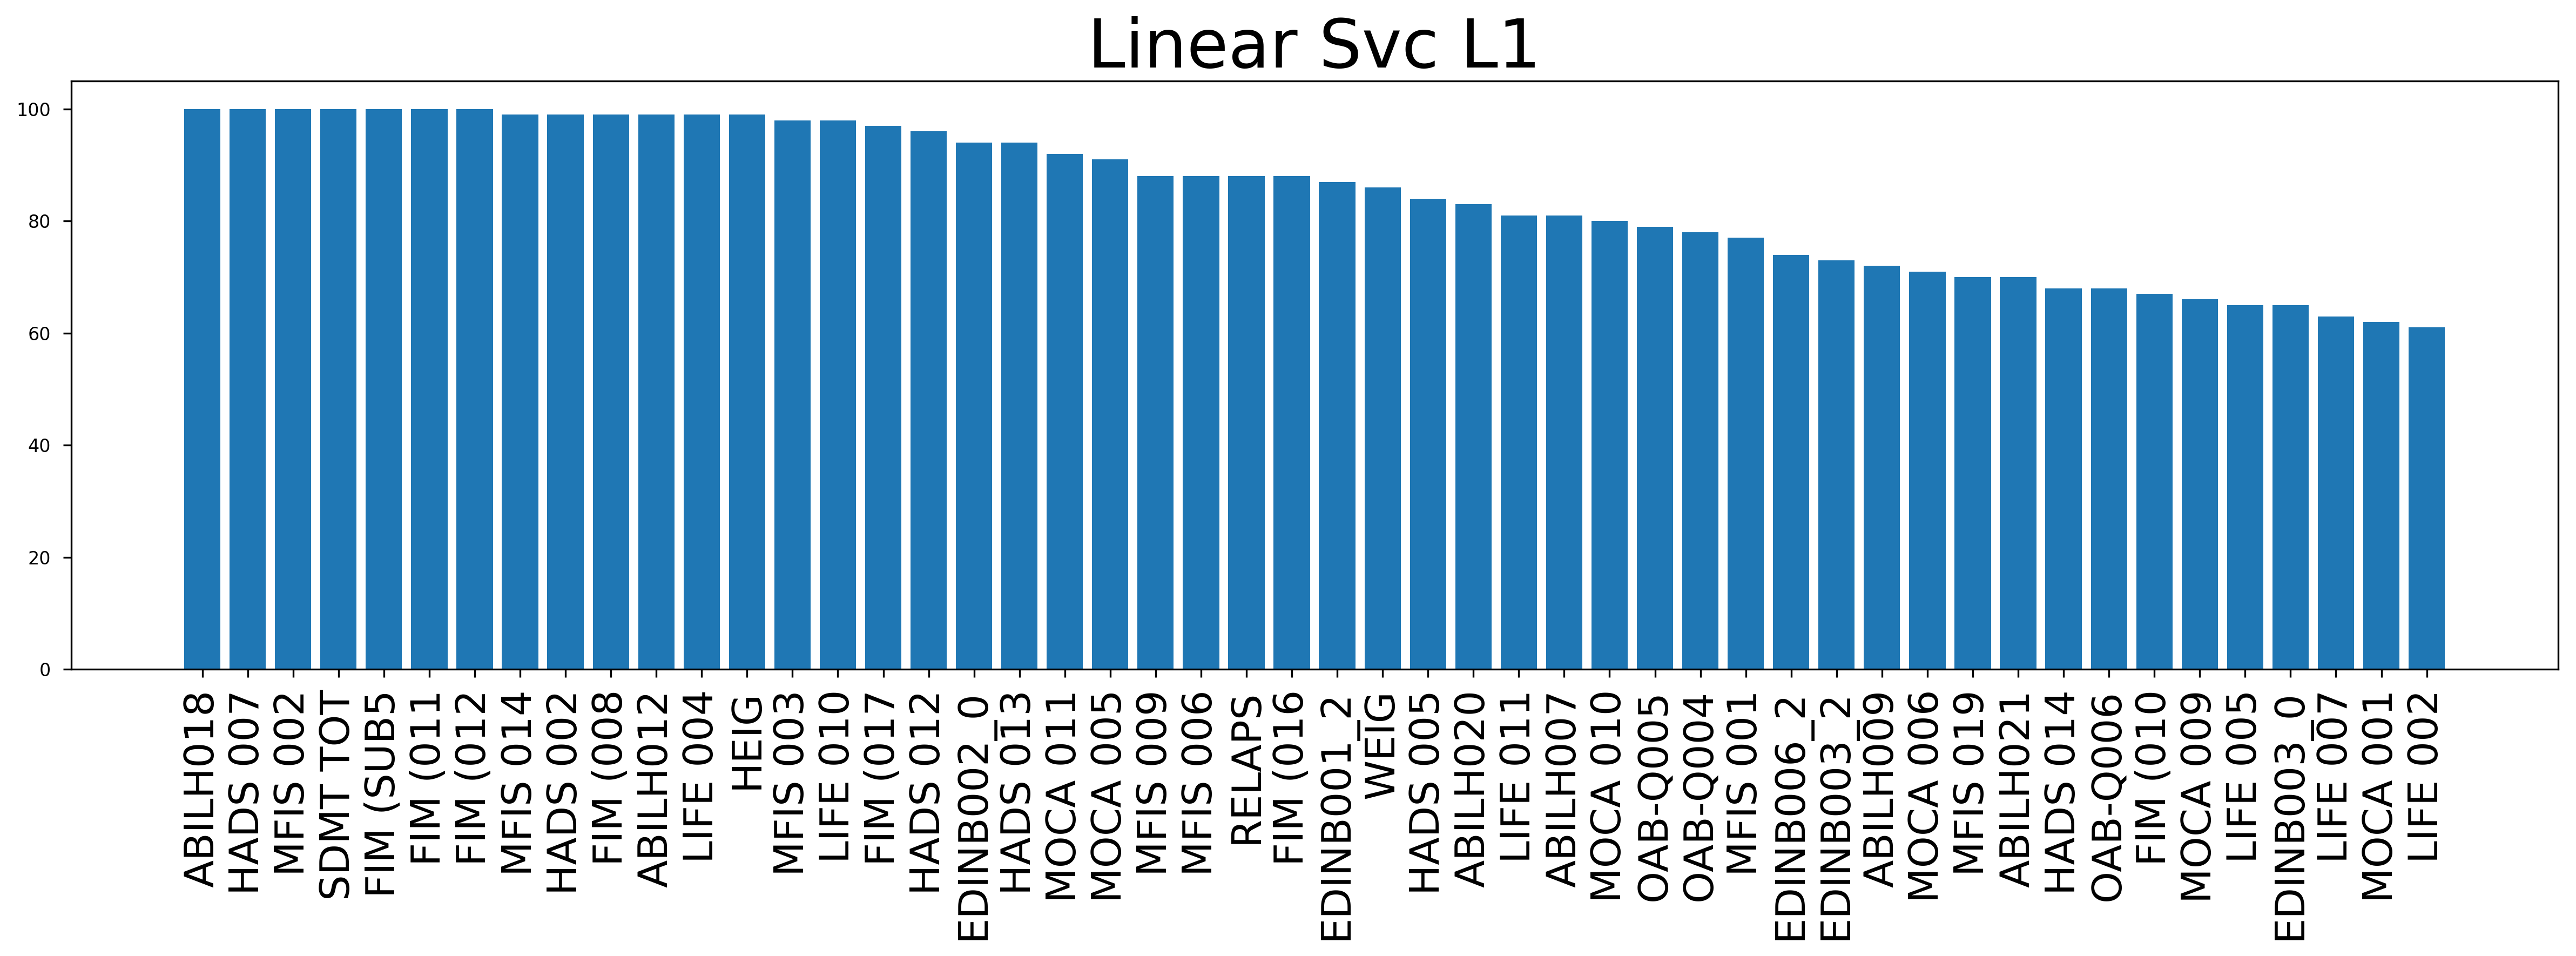

In [6]:
from collections import Counter

for i, name in enumerate(names):
    c = dict(Counter(flatten([c.tolist() for c in coefs[name]])))
    c = pd.DataFrame(data=c.values(), index=c.keys(), columns=['selections'])
    
    idx = np.argsort(c.values.ravel())[::-1]
      
    # plot selection
    plt.figure(dpi=300, figsize=(16, 6))
    plt.bar(range(c.shape[0])[:50], c['selections'].iloc[idx].values[:50])
    plt.xticks(range(c.shape[0])[:50], c.index[idx][:50], rotation=90, fontsize=18)
    plt.title(name.replace('_',' ').title(), fontsize=30)
    plt.tight_layout()

In [14]:
# Save signature csv
name = 'random_forests'
c = dict(Counter(flatten([c.tolist() for c in coefs[name]])))
c = pd.DataFrame(data=c.values(), index=c.keys(), columns=['selections']).sort_values(by='selections', ascending=False)
idx = np.where(c.values >= 95)[0] # threshold learned otpimizing on the test set, see aism_learning_f_best_cut
c.iloc[idx].to_csv('random_forests_signature.csv')
c.iloc[idx]

,selections
MFIS SUB1,100
FIM (014,100
MOCA TOT,100
HEIG,100
MFIS SUB3,100
MFIS SUB2,100
SDMT TOT,100
FIM (012,100
FIM (011,100
FIM (010,100
